In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os
from scipy.sparse import diags

START_YEAR = 1992
END_YEAR = 2020
HEM = 'sh'
VERSION = 'V3'

######################################################################
# Same as V2 but changes paths to use uncertainty without mean removed
######################################################################

PATH_SOURCE = "/home/jbassham/jack/old-thesis/data/sh/inputs_v2"
PATH_DEST = "/home/jbassham/jack/old-thesis/data/sh/outputs_v2"

In [2]:
def lr_weighted_train(invars, epsilon = 1e-4):
   
    # Get ice velocity for nan filtering
    uit = invars[0]
    vit = invars[1]

    # Get dimensions for output arrays
    nt, ny, nx = np.shape(invars[0])
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices and unpack input list
                    uit_f, vit_f, rt_f, uwt_f, vwt_f, icy_f = [var[true_mask,iy,ix] for var in invars]

                    # Convert to complex
                    it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
                    icy_c = icy_f + icy_f*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Create 'Complex' squared uncertainty for weighting
                    # NOTE (u + iv) * (u + iv) = u**2 + 2iuv - v**2
                    # if r = u = v, then r**2 = 2uv = 2r**2
                    # This gives us the projection of uncertainty on complex ice velocity
                    # NOTE i needed here?
                    r_c = 2 * ((rt_f ** 2))

                    # Inverse uncertainty squared for weights
                    w = 1 / (r_c + epsilon)

                    # Diagonalize matrix of inverse uncertainty squared for weights
                    # NOTE scipy.sparse diags used for memory efficiency
                    W = diags(w)
                    
                    # Solve for model parameters
                    m = (LA.inv((G.conj().T @ W @ G))) @ G.conj().T @ W @ d # (adapted from eqn 39, SIOC221B Lec 10)

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

In [3]:
def lr_predict(invars, m):

    # Get ice velocity for nan filtering
    uit = invars[0]
    vit = invars[1]

    # Get dimensions for output arrays
    nt, ny, nx = np.shape(invars[0])
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    pred_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Filter inputs to valid indices
            uit_f, vit_f, _, uwt_f, vwt_f, icy_f = [var[:,iy,ix] for var in invars]

            # Convert to complex
            it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
            wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
            icy_c = icy_f + 0*1j # Complex 'yesterday' ice concentration
            
            # Store true complex ice velocity vectors at valid points
            true_all[:, iy, ix] = it_c

            # Define gram matrix
            G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

            G[:,1] = wt_c # Complex wind, today
            G[:,2] = icy_c # Complex ice concentration, yesterday

            m_grid = m[:,iy,ix]

            # Calculate fit
            pred = G @ m_grid
            
            # Store predicted complex ice velocity vectors at valid points
            pred_all[:, iy, ix] = pred

        print(f'iy {iy} complete')
        
    return pred_all, true_all

In [4]:
# Load in new LR train input variable file
fnam = '/home/jbassham/jack/thesis-rough/data/lr-input/sh/01212026_1222/train_sh19922020_01212026_1222.npz'
data = np.load(fnam)

# Unpack input variables from .npz file
x_train = data['x_train']
y_train = data['y_train']

rt_tr = data['r_train']

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(rt_tr))

uit_tr = y_train[:,0,:,:]
vit_tr = y_train[:,1,:,:]

uwt_tr = x_train[:,0,:,:]
vwt_tr = x_train[:,1,:,:]
icy_tr = x_train[:,2,:,:]

# Pack input variables into list
invars_train = [uit_tr, vit_tr, rt_tr, uwt_tr, vwt_tr, icy_tr]

(9131, 3, 81, 522)
(9131, 2, 81, 522)
(9131, 81, 522)


In [5]:
# # V2 INPUTS

# # Load input variable file
# fnam = f'inputs_normalized_{HEM}_{START_YEAR}_{END_YEAR}.npz'
# data = np.load(os.path.join(PATH_SOURCE, fnam))

# # Unpack input variables from .npz file
# uit = data['uitn']
# vit = data['vitn']
# rt = data['rtn']
# uwt = data['uwtn']
# vwt = data['vwtn']
# icy = data['icyn']

# # Pack input variables into list
# invars = [uit, vit, rt, uwt, vwt, icy]

# print("Input Variables Loaded")

# # Load time (dates)
# fnam = f"time_today_{HEM}_{START_YEAR}_{END_YEAR}.npz"
# data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
# time_today = data['time_today']

# print("Dates Loaded")

# # Load lat lon grid for plotting
# fnam = f'lat_lon_{HEM}.npz'
# data = np.load(os.path.join(PATH_SOURCE, fnam))
# lat = data['lat']
# lon = data['lon']
# print("Lat Lon Loaded")

In [6]:
# # V2 INPUTS SPLIT

# # Generate train, test splits
# # NOTE no val for LR

# years = time_today.astype('datetime64[Y]').astype(int) + 1970

# # Define ranges
# train_mask = (years >= 1992) & (years <= 2016)
# test_mask = (years >= 2019) & (years <= 2020)

# # Get indices
# train_idx = np.where(train_mask)[0]
# test_idx  = np.where(test_mask)[0]

# invars_train = [var[train_idx, :, :] for var in invars]
# invars_test = [var[test_idx, :, :] for var in invars]


# print('Train Test split complete')

In [7]:
# Train linear regression
m, fit_train, true_train = lr_weighted_train(invars_train)

print("All Training Points Complete")

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

In [8]:
# Load in new LR test input variable file
fnam = '/home/jbassham/jack/thesis-rough/data/lr-input/sh/01212026_1222/test_sh19922020_01212026_1222.npz'
data = np.load(fnam)

# Unpack input variables from .npz file
x_test = data['x_test']
y_test = data['y_test']

rt_te = data['r_test']

print(np.shape(x_test))
print(np.shape(y_test))

uit_te = y_test[:,0,:,:]
vit_te = y_test[:,1,:,:]

uwt_te = x_test[:,0,:,:]
vwt_te = x_test[:,1,:,:]
icy_te = x_test[:,2,:,:]

# Pack input variables into list
invars_test = [uit_te, vit_te, rt_te, uwt_te, vwt_te, icy_te]

(731, 3, 81, 522)
(731, 2, 81, 522)


In [9]:
# Test linear regression
pred_test, true_test = lr_predict(invars_test, m)

print("All testing Points Complete")

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

In [10]:
# # Save output
# fnam = f'wlr_train_{HEM}_{START_YEAR}_{END_YEAR}_{VERSION}.npz'

# np.savez(os.path.join(PATH_DEST, fnam), m = m, fit_train = fit_train, true_train = true_train)

# print(f"LR training outputs saved at: \n {PATH_DEST}/{fnam}")

In [11]:
# # Save output
# fnam = f'wlr_pred_{HEM}_{START_YEAR}_{END_YEAR}_{VERSION}.npz'

# np.savez(os.path.join(PATH_DEST, fnam), pred_test = pred_test, true_test = true_test)

# print(f"LR testing outputs saved at: \n {PATH_DEST}/{fnam}")

In [12]:
# # Plot / Verify outputs

# import matplotlib.pyplot as plt

In [13]:
## FOR PLOTTING 

def skill(fit, true):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

def return_plot_skill(fit, true, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    # Calculate skill of complex output (the ice velocity vector)
    skill_z = skill(fit, true)
    # NOTE: Variance of complex input returned as Var(z)=E[(z−E[z])**2
    # so a real number is returned that represents the spread in both u and v components of the vector
    
    skill_u = skill(np.real(fit), np.real(true))
    skill_v = skill(np.imag(fit), np.imag(true))
    
    data = [skill_z, skill_u, skill_v]
    titles = ['vector', 'u', 'v']
    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), constrained_layout=True)
    
    for i in range(3):
        pcm = axs[i].pcolormesh(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Skill {model}')
    plt.show()
    
    return skill_z, skill_u, skill_v

/tmp/ipykernel_861667/2550988538.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_861667/2550988538.py:5: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


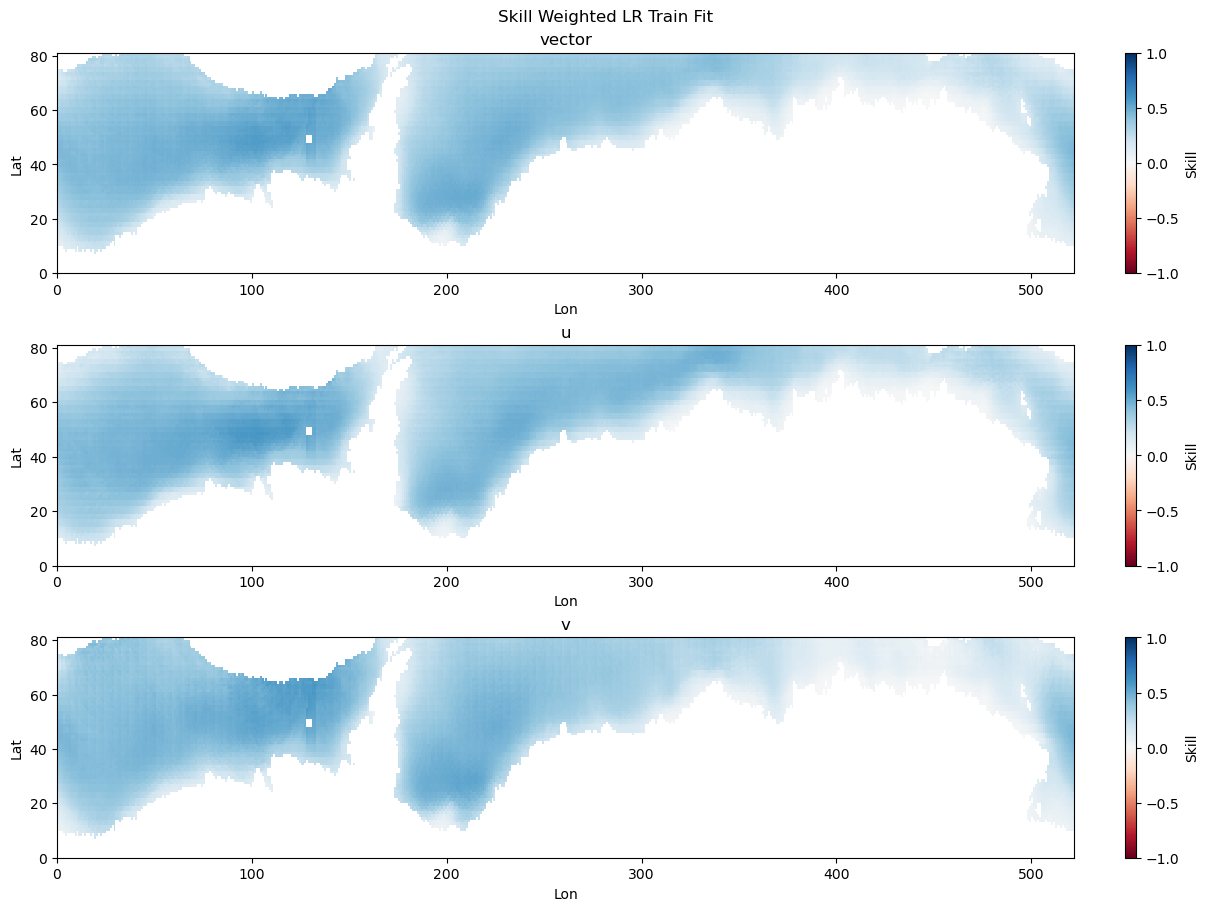

In [14]:
_, _, _ = return_plot_skill(fit_train, true_train, f'Weighted LR Train Fit')

/tmp/ipykernel_861667/2550988538.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_861667/2550988538.py:5: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


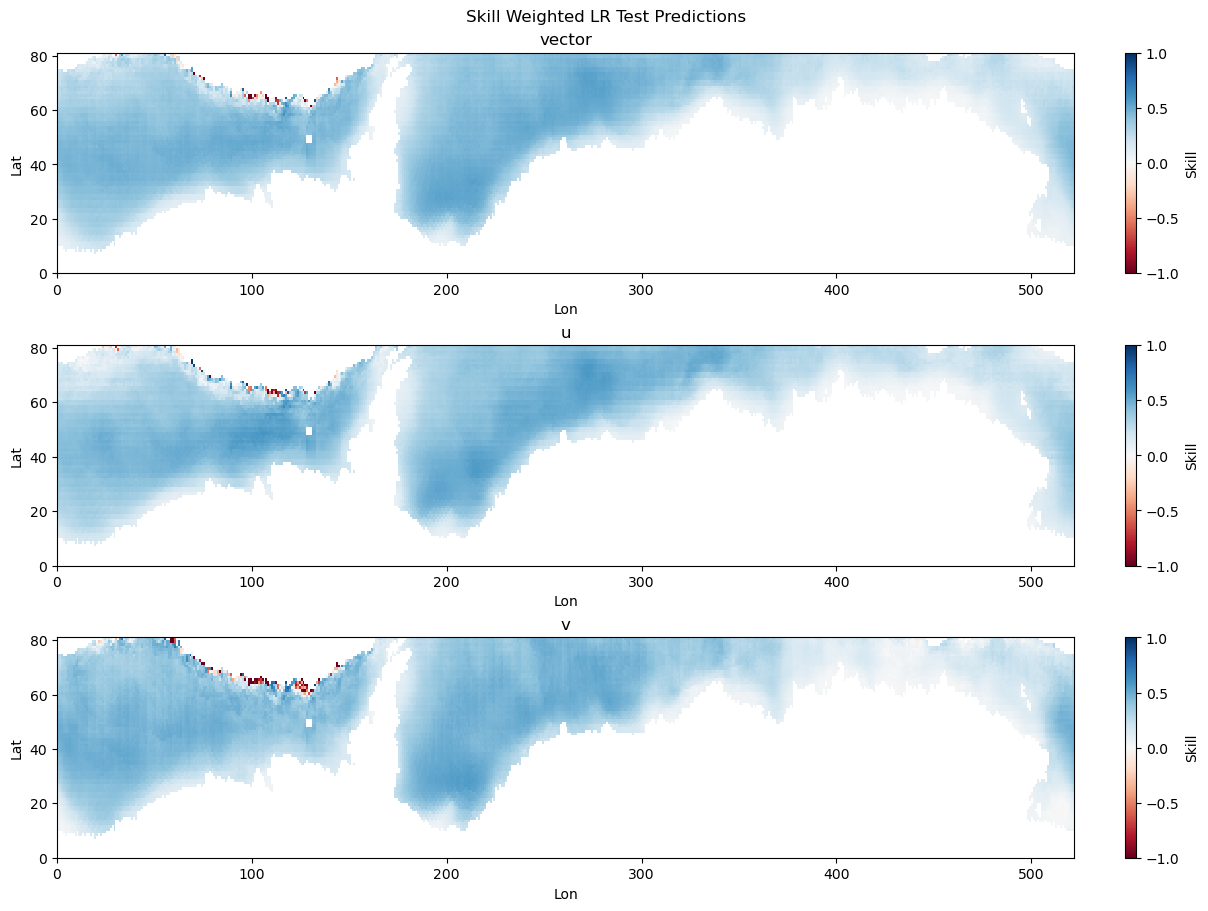

In [15]:
_, _, _ = return_plot_skill(pred_test, true_test, f'Weighted LR Test Predictions')